### Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator 
from yellowbrick.cluster import silhouette_visualizer 
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.datasets import make_blobs

from decimal import Decimal

In [16]:
silhouette_dict = {}
def kmeans_label(data, num_clusters): 
    kmeans_model = KMeans(init = 'random', n_clusters = num_clusters, random_state=42)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data.to_numpy()) 
    kmeans_model.fit(scaled_features)
    data2 = data.copy()
    labels = kmeans_model.labels_
    data2['Clusters'] = pd.DataFrame(labels)
    return data2

def plot_boxplots(data_with_label):
    plt.figure(figsize=(30,30))
    sns.set(font_scale = 2)
    for i in range(len(data_with_label.columns)-1):
        plt.subplot(2,5,i+1)
        sns.boxplot(y=data_with_label.columns[i], x='Clusters', data=data_with_label, palette="colorblind") 
    
def plot_silhouettes(data,num_clusters):
    scaler = StandardScaler()
    dataarray = scaler.fit_transform(data.to_numpy()) 
    model = KMeans(num_clusters,random_state=42)
    plt.figure(figsize=(10, 7)) 
    sns.set(font_scale = 1)
    silhouette_visualizer(model, dataarray, colors='yellowbrick')
    score = silhouette_score(dataarray, model.labels_,metric = 'euclidean')
    if num_clusters not in silhouette_dict.keys():
        silhouette_dict[num_clusters] = score
    print("For n_clusters = {0} The average silhouette_score is: {1} ".format(num_clusters,score))

### Clustering on Aggregate Data

In [2]:
bike_agg = pd.read_csv('../PCA/bike_agg_with_season_no.csv')
bike_agg = bike_agg[bike_agg.rent_count > 0].reset_index(drop=True)

In [3]:
bike_agg.head()

,Unnamed: 0,date,rent_count,temperature,rainfall,snowfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity,season,holiday,season_no
0,1,2017-12-01,9539,-1.10,0.0,0,1.4,20000,0.0,-17.40,37.5,Winter,No Holiday,4
1,2,2017-12-02,8523,2.70,0.0,0,1.6,14410,0.0,-5.55,55.5,Winter,No Holiday,4
2,3,2017-12-03,7222,4.35,4.0,0,1.6,3380,0.0,2.65,84.5,Winter,No Holiday,4
3,4,2017-12-04,8729,-0.25,0.1,0,3.6,19130,0.0,-12.95,43.5,Winter,No Holiday,4
4,5,2017-12-05,8307,-3.80,0.0,0,0.0,20000,0.0,-17.70,34.5,Winter,No Holiday,4


In [4]:
bike_agg.describe()

,Unnamed: 0,rent_count,temperature,rainfall,snowfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity,season_no
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,177.000000,17485.308782,12.606232,3.575921,18.628895,1.640935,14681.076487,0.109589,3.850992,57.957507,2.484419
std,102.046558,9937.164768,11.568233,11.789868,88.044126,0.661204,5578.420791,0.154109,13.194681,16.100348,1.128359
min,1.000000,977.000000,-14.850000,0.000000,0.000000,0.000000,2185.000000,0.000000,-27.900000,22.000000,1.000000
25%,89.000000,6967.000000,2.900000,0.000000,0.000000,1.150000,9795.000000,0.000000,-5.350000,46.500000,1.000000
50%,177.000000,18563.000000,13.500000,0.000000,0.000000,1.500000,16765.000000,0.015000,4.550000,56.000000,2.000000
75%,265.000000,26285.000000,22.400000,0.500000,0.000000,1.950000,19875.000000,0.190000,15.200000,69.000000,4.000000
max,353.000000,36149.000000,33.100000,95.500000,787.000000,4.000000,20000.000000,0.575000,25.000000,97.000000,4.000000


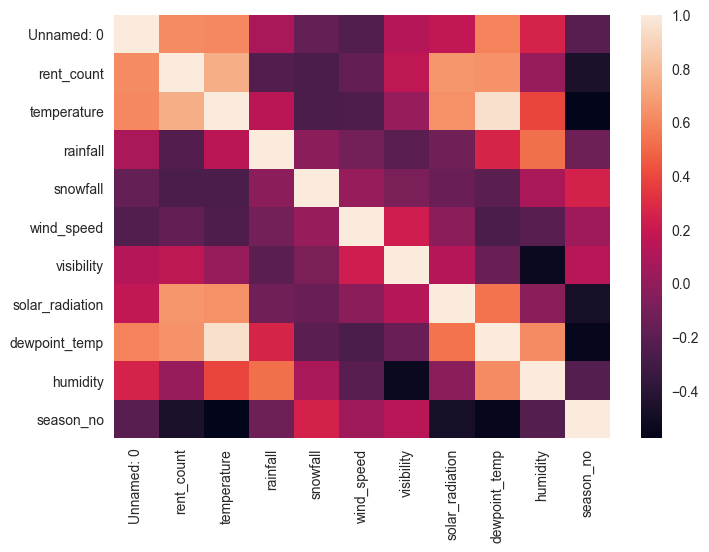

In [5]:
sns.heatmap(bike_agg.corr())
plt.show()

## K means clustering
### Scaling Data

In [7]:
# drop categorical var: holiday, season
# drop dewpoint_temp (correlated with temperature
# drop rainfall & snowfall (more than 93% is 0)

In [8]:
df_kmean_agg = bike_agg.drop(columns = ['Unnamed: 0','holiday', 'season', 'date',
                               'rainfall', 'snowfall', 'dewpoint_temp', 'season_no'])

In [9]:
df_kmean_agg.columns

Index(['rent_count', 'temperature', 'wind_speed', 'visibility',
       'solar_radiation', 'humidity'],
      dtype='object')

In [10]:
dataarray = df_kmean_agg.to_numpy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray) 

### Evaluating WCSS

In [11]:
wcss = []
max_k = 14
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

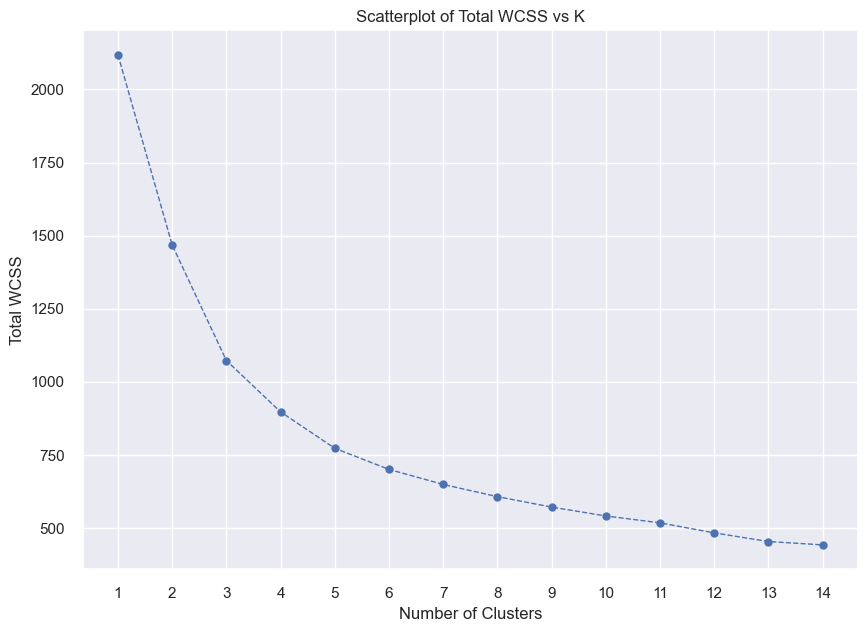

In [12]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [13]:
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

4

### Evaluating Silhouette Score

In [14]:
silhouette_coefficients = []

for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

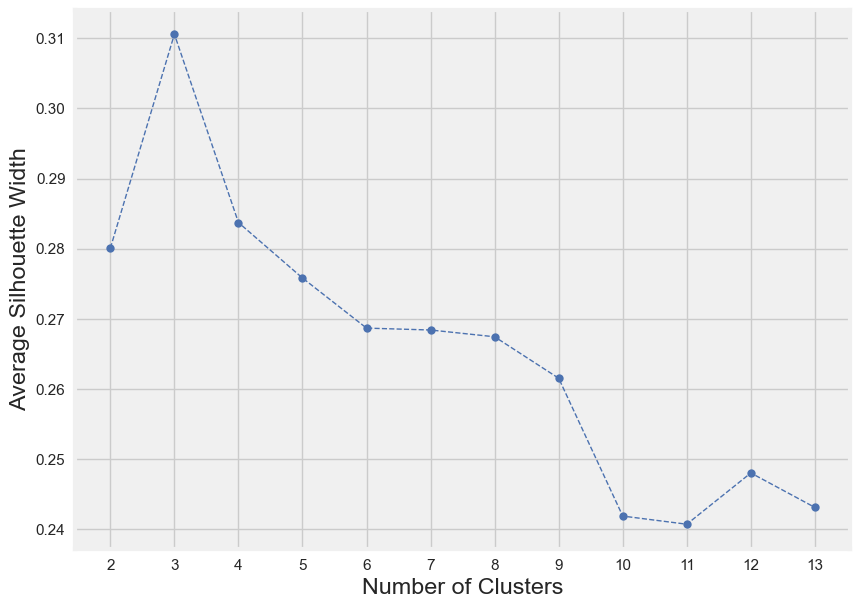

In [15]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

### Kmeans with 4 clusters

In [24]:
kmeans4 = KMeans(init="random",n_clusters = 4 , random_state = 42)
kmeans4.fit(scaled_features)
clustergroups4 = kmeans4.labels_

In [25]:
print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups4)}')

CH score: 158.2055017315656


In [26]:
model4 = kmeans_label(df_kmean_agg, 4)
model4.head()

,rent_count,temperature,wind_speed,visibility,solar_radiation,humidity,Clusters
0,9539,-1.10,1.4,20000,0.0,37.5,1
1,8523,2.70,1.6,14410,0.0,55.5,1
2,7222,4.35,1.6,3380,0.0,84.5,0
3,8729,-0.25,3.6,19130,0.0,43.5,1
4,8307,-3.80,0.0,20000,0.0,34.5,1


In [27]:
model4.Clusters.value_counts(dropna=False)

3    96
1    88
0    87
2    82
Name: Clusters, dtype: int64

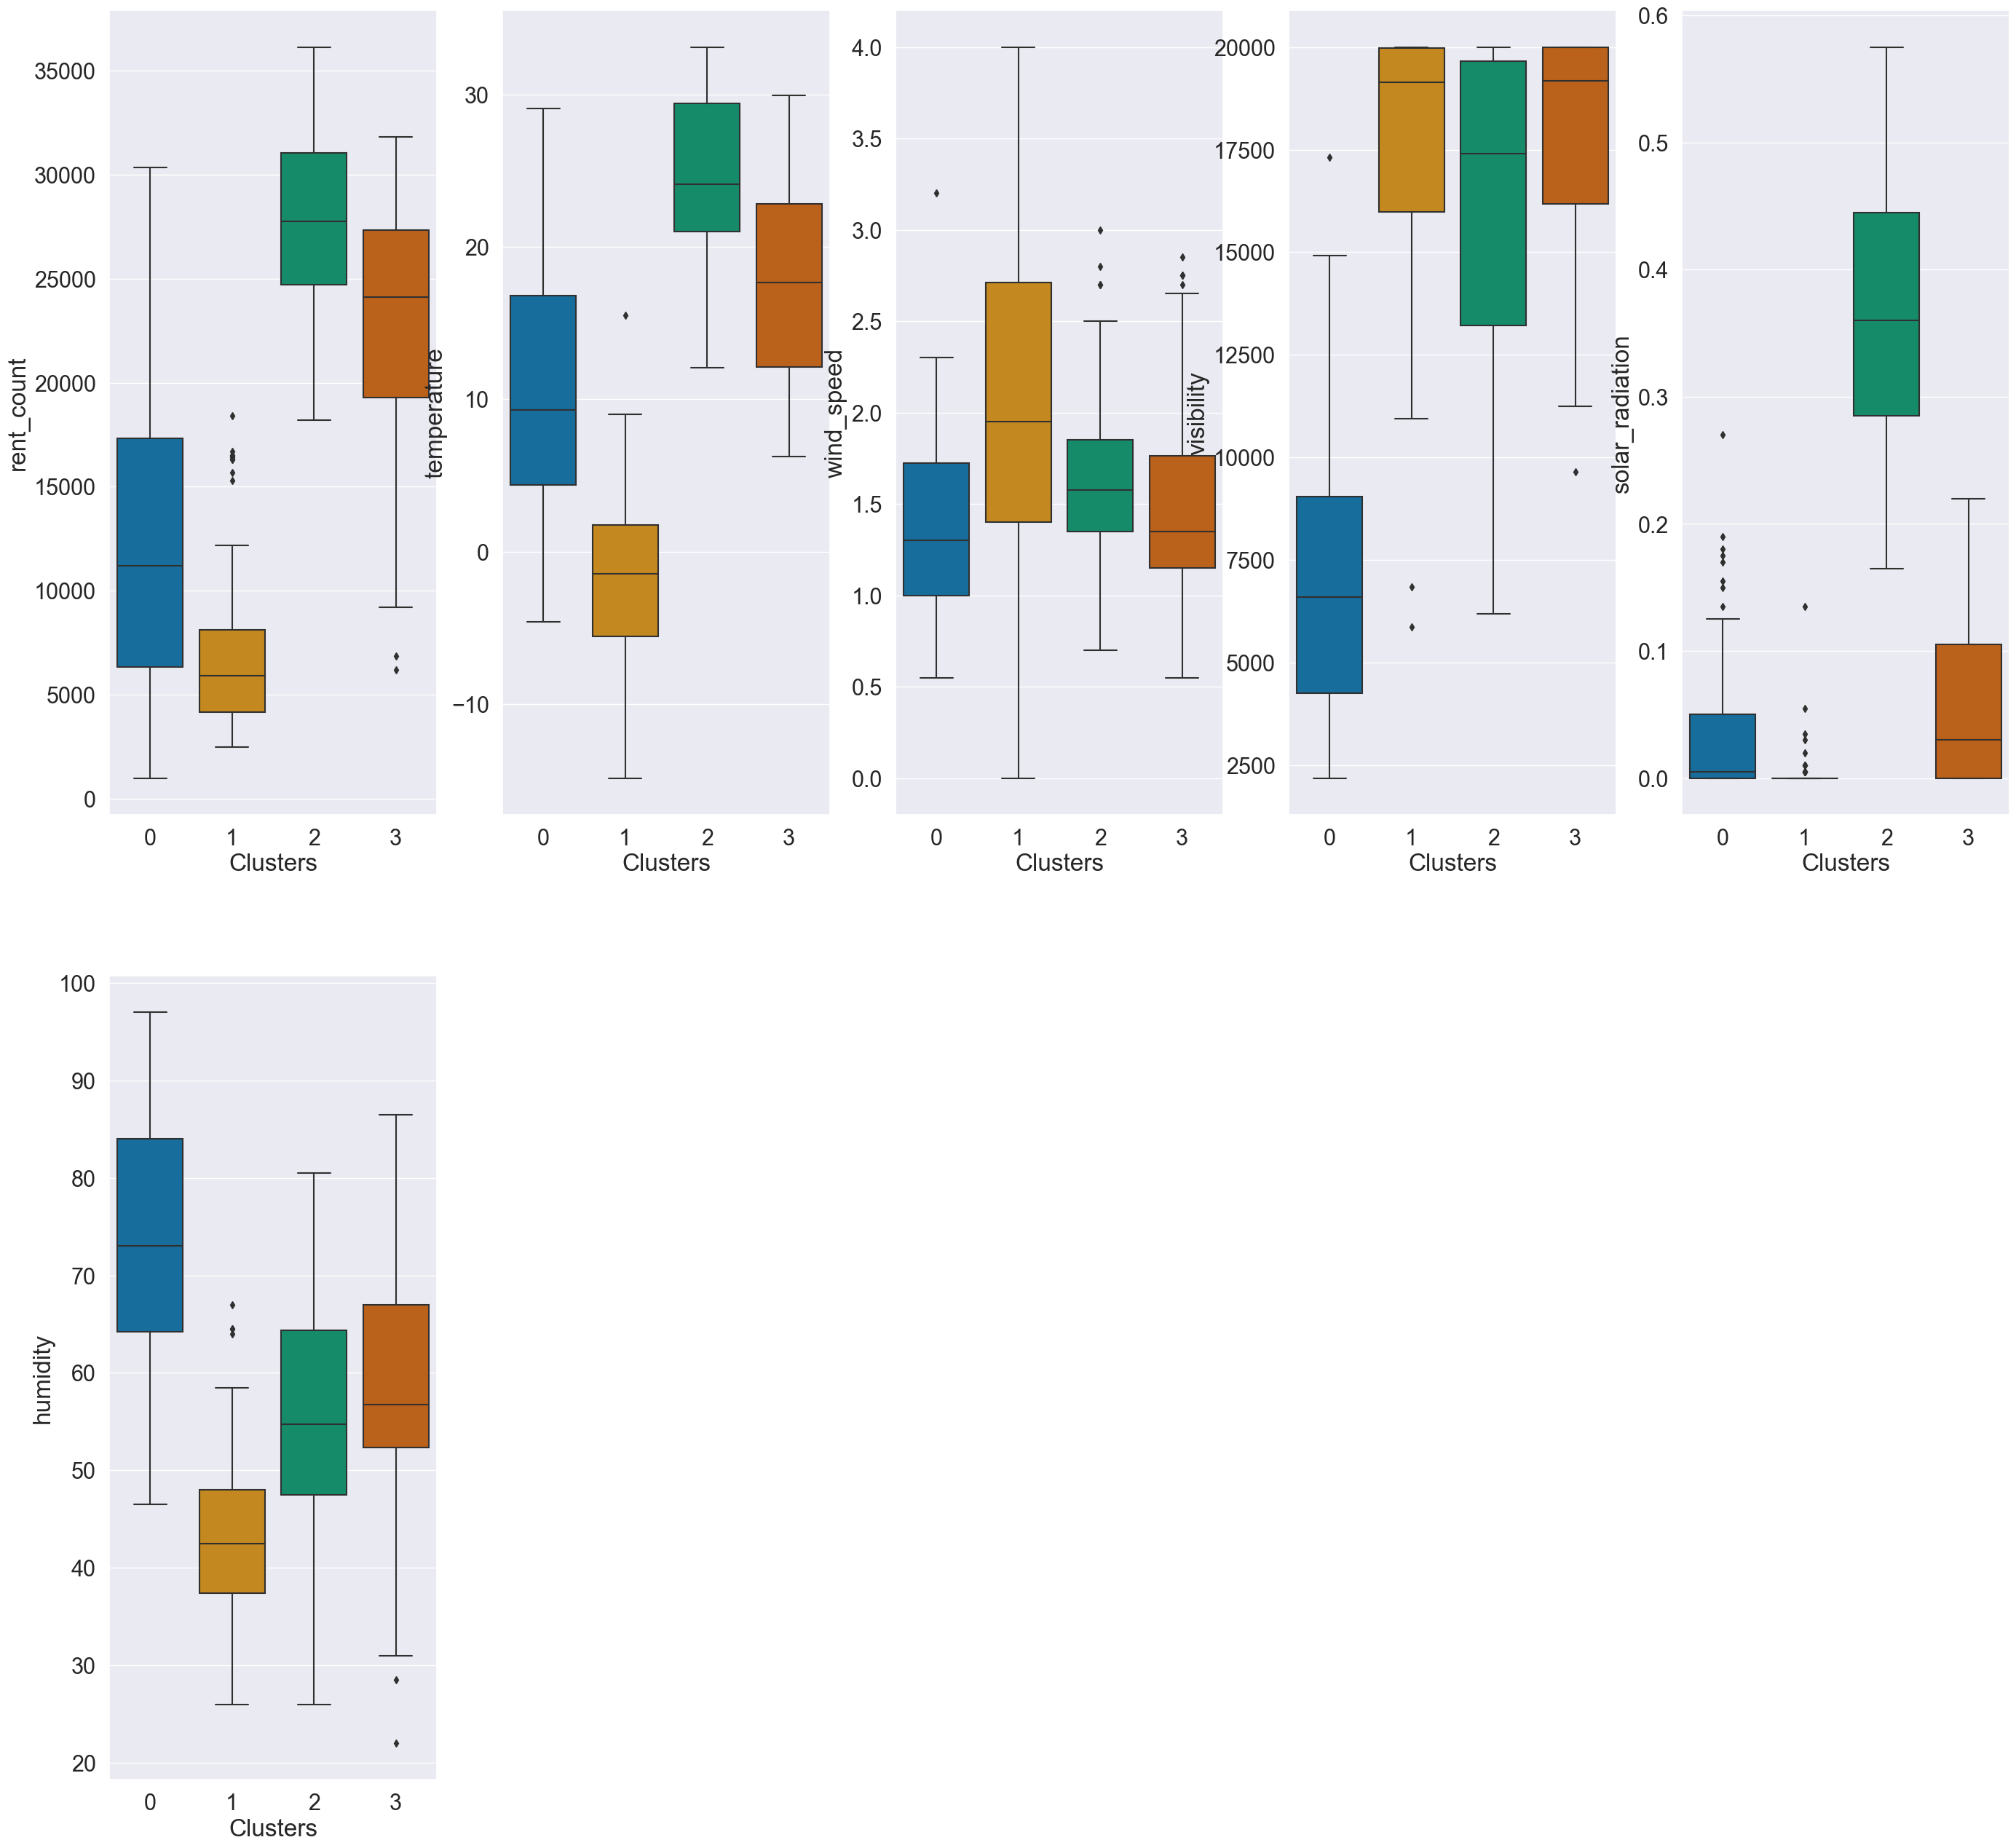

In [28]:
plot_boxplots(model4)
plt.show()

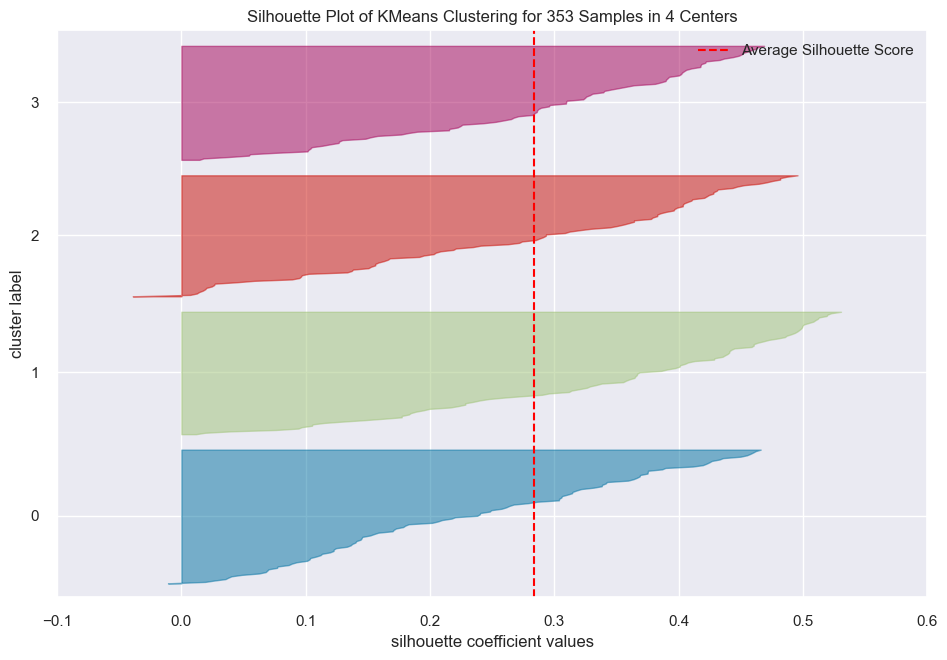

For n_clusters = 4 The average silhouette_score is: 0.28372758262588144 


In [29]:
plot_silhouettes(df_kmean_agg,4)
plt.show()

In [30]:
Clustercenters4 = pd.DataFrame(scaler.inverse_transform(kmeans4.cluster_centers_), columns = df_kmean_agg.columns)

In [31]:
Clustercenters4

,rent_count,temperature,wind_speed,visibility,solar_radiation,humidity
0,12450.609195,10.802874,1.380460,6968.448276,0.034713,74.011494
1,6955.079545,-1.884659,2.079545,17673.465909,0.003807,43.073864
2,27661.390244,24.277439,1.623171,15947.256098,0.361037,55.304878
3,23008.645833,17.554688,1.490104,17846.093750,0.059635,59.317708


In [32]:
final_cluster = pd.concat([model4, bike_agg[['season', 'holiday', 'rainfall', 'snowfall', 'dewpoint_temp']]], axis = 1)

In [46]:
cluster_rainfall = final_cluster.groupby('Clusters').rainfall.mean()
cluster_snowfall= final_cluster.groupby('Clusters').snowfall.mean()
cluster_dewpt =  final_cluster.groupby('Clusters').dewpoint_temp.mean()

In [47]:
cluster_season = final_cluster.groupby('Clusters').season.agg(pd.Series.mode).to_frame()

In [48]:
cluster_holiday = final_cluster.groupby('Clusters').holiday.agg(pd.Series.mode).to_frame()

In [49]:
final_cluster_center = pd.concat([Clustercenters4,cluster_season, cluster_holiday, cluster_rainfall, cluster_snowfall, cluster_dewpt], axis=1)
final_cluster_center

,rent_count,temperature,wind_speed,visibility,solar_radiation,humidity,season,holiday,rainfall,snowfall,dewpoint_temp
0,12450.609195,10.802874,1.380460,6968.448276,0.034713,74.011494,Spring,No Holiday,10.539080,37.666667,5.991954
1,6955.079545,-1.884659,2.079545,17673.465909,0.003807,43.073864,Winter,No Holiday,0.404545,37.488636,-13.777841
2,27661.390244,24.277439,1.623171,15947.256098,0.361037,55.304878,Summer,No Holiday,0.379268,0.000000,14.440244
3,23008.645833,17.554688,1.490104,17846.093750,0.059635,59.317708,Autumn,No Holiday,2.903125,0.000000,9.025521


<center><u> clusters on seasons </u></center>

| | Cluster 0 | Cluster 2 | Cluster 3 | Cluster 1 |
| -- | --- | --- | --- | --- |
|season: | spring | summer | autumn | winter | 
|daily rent count: | low | high | high | low |
|temp: | low | high | high | low |
|visibility: | low | high | high | high |
|rainfall: | high | low | low | low |
|snowfall: | high | low | low | high | 

---

<center><u> low daily rent count clusters </u></center>

| | Cluster 0 | Cluster 1 | 
| -- | --- | --- | 
|season: | spring |  winter | 
|temp: | low | low |
|visibility: | low |  high |
|rainfall: | high | low |
|snowfall: | high |  high | 


<center><u>high daily rent count clusters </u></center>

| | Cluster 2 | Cluster 3 |
| -- | --- | --- |
|season: | summer | autumn | 
|temp:  | high | high |
|visibility: | high | high |
|rainfall: | low | low | 
|snowfall: | low | low | 



In [309]:
bike_agg.describe()

,Unnamed: 0,rent_count,temperature,rainfall,snowfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity,season_no
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,177.000000,17485.308782,12.606232,3.575921,18.628895,1.640935,14681.076487,0.109589,3.850992,57.957507,2.484419
std,102.046558,9937.164768,11.568233,11.789868,88.044126,0.661204,5578.420791,0.154109,13.194681,16.100348,1.128359
min,1.000000,977.000000,-14.850000,0.000000,0.000000,0.000000,2185.000000,0.000000,-27.900000,22.000000,1.000000
25%,89.000000,6967.000000,2.900000,0.000000,0.000000,1.150000,9795.000000,0.000000,-5.350000,46.500000,1.000000
50%,177.000000,18563.000000,13.500000,0.000000,0.000000,1.500000,16765.000000,0.015000,4.550000,56.000000,2.000000
75%,265.000000,26285.000000,22.400000,0.500000,0.000000,1.950000,19875.000000,0.190000,15.200000,69.000000,4.000000
max,353.000000,36149.000000,33.100000,95.500000,787.000000,4.000000,20000.000000,0.575000,25.000000,97.000000,4.000000


In [366]:
final_pca_cluster = pd.concat([Clustercenters5,pca_season, pca_holiday, pca_dewpt], axis=1)
final_pca_cluster

,principal component 1,principal component 2,principal component 3,rent_count,season,holiday,dewpoint_temp
0,-0.283327,0.869335,0.056378,26892.696774,Summer,No Holiday,12.379032
1,-0.633013,-1.059865,0.535232,7878.263736,Winter,No Holiday,-12.993956
2,3.738290,-0.404973,1.072022,4863.750000,"[Spring, Summer]",No Holiday,16.970833
3,0.699387,-0.230491,-0.370961,13728.302326,Spring,No Holiday,5.448256
4,-0.387423,-1.513037,-4.267367,5336.111111,Winter,No Holiday,-5.455556


In [367]:
pca_label

,PC1,PC2,PC3
temperature,,0.899195,
rainfall,0.817194,,
snowfall,,,-0.693697
wind_speed,,,0.555481
visibility,-0.594626,,
solar_radiation,,0.850287,
humidity,0.845882,,


In [368]:
model5.Clusters.value_counts(dropna=False)

0    155
1     91
3     86
2     12
4      9
Name: Clusters, dtype: int64

PC1: rainy and not visible   
PC2: hot and sunny    
PC3: windy and not snowy     

<center><u> low daily rent count clusters </u></center>

| | Cluster 0 | Cluater 1 | Cluster 2 | 
| -- | --- | --- | --- | 
|season: | spring, summer | winter | winter |
|PC1: | high | medium | low | 
|PC2: | high | low | medium |
|PC3: | high | low | medium |

<center><u>high daily rent count clusters </u></center>

| | Cluster 3 | Cluater 4 | 
| -- | --- | --- |
|season: | spring | summer |
|PC1: | high | low | 
|PC2: | low | high |
|PC3: | low | high |